In [2]:
import pandas as pd
from core import med_log_odds_cutoff
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from joblib import Parallel, delayed

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

## Recluster E. coli

In [7]:
cov = 0.8
cov_mode = 0
min_seq_id = 0.3
threads = 40
cluster_mode = 0

In [8]:
unique_seq_db = '../data/ecoli/interim/mmseqs/unique_seqs.db'

In [9]:
clust_db = '../data3/interim/mmseqs_dbs/ecoli_3k_clust'

In [10]:
%%time 
!conda run -n beaker \
mmseqs cluster {unique_seq_db} {clust_db} ../data/tmp \
-c {cov} --cov-mode {cov_mode} \
--min-seq-id {min_seq_id} --threads {threads} \
--cluster-mode {cluster_mode} -s 6

cluster ../data/ecoli/interim/mmseqs/unique_seqs.db ../data3/interim/mmseqs_dbs/ecoli_3k_clust ../data/tmp -c 0.8 --cov-mode 0 --min-seq-id 0.3 --threads 40 --cluster-mode 0 -s 6 

MMseqs Version:                     	13.45111
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	6
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask lower cas

In [4]:
clust_out = '../data3/interim/ecoli_3k_seq_clusters.txt'

In [12]:
!conda run -n beaker \
mmseqs createtsv {unique_seq_db} {unique_seq_db} {clust_db} {clust_out}

createtsv ../data/ecoli/interim/mmseqs/unique_seqs.db ../data/ecoli/interim/mmseqs/unique_seqs.db ../data3/interim/mmseqs_dbs/ecoli_3k_clust ../data3/interim/ecoli_3k_seq_clusters.txt 

MMseqs Version:                 	13.45111
First sequence as representative	false
Target column                   	1
Add full header                 	false
Sequence source                 	0
Database output                 	false
Threads                         	80
Compressed                      	0
Verbosity                       	3

Time for merging to ecoli_3k_seq_clusters.txt: 0h 0m 0s 888ms
Time for processing: 0h 0m 3s 915ms



In [5]:
cluster_df = pd.read_table(clust_out, names=['cluster_id', 'product_accession'])

In [6]:
cluster_df['cluster_id'].nunique()

77176

## Read in predictions

In [7]:
prediction_out_dir = '../data3/interim/ecoli_predictions/'

In [8]:
predictions = pd.concat([pd.read_parquet(prediction_out_dir + f) for 
                         f in tqdm(os.listdir(prediction_out_dir), position=0) if '_predictions.pq' in f])

100%|██████████| 6000/6000 [04:42<00:00, 21.20it/s]


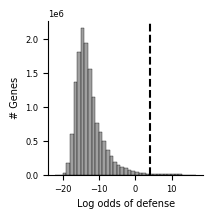

In [9]:
plt.subplots(figsize=(2,2))
sns.histplot(predictions['mean_log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()

In [10]:
predictions['predicted_defensive'] = predictions['mean_log_odds'] > med_log_odds_cutoff

In [11]:
predictions['predicted_defensive'].sum()

95107

## Add DefenseFinder results

In [12]:
cat_system_df = pd.read_csv('../data/ecoli/interim/defense_finder_full_systems_genes.csv')
cat_homolog_df = pd.read_csv('../data/ecoli/interim/defense_finder_homologs.csv')

In [13]:
unique_homolog_df = (cat_homolog_df.groupby(['hit_id','assembly_stub'])
                     .sample(n=1, random_state=7))

In [14]:
unique_system_df = (cat_system_df.sort_values('sys_score', ascending=False)
                    .groupby(['assembly_stub', 'hit_id'])
                    .head(1))

## Merge and analyze

In [15]:
merged_predictions = predictions.copy()
merged_predictions['assembly_stub'] = merged_predictions['assembly'].str.split('.', expand=True)[0]
merged_predictions = (merged_predictions.merge(unique_homolog_df[['hit_id', 'gene_name', 'assembly_stub']]
                                               .rename(columns={'hit_id': 'product_accession', 
                                                                             'gene_name': 'defense_homolog_name'}),
                                        how='left', on=['product_accession', 'assembly_stub']))
merged_predictions['defense_homolog'] = ~merged_predictions['defense_homolog_name'].isna()
merged_predictions = (merged_predictions.merge(unique_system_df[['assembly_stub', 'hit_id','gene_name', 'sys_id']]
                                               .rename(columns={'hit_id': 'product_accession', 
                                                                'gene_name': 'defense_system_gene', 
                                                                'sys_id': 'defense_system'}), 
                                               how='left', on=['product_accession', 'assembly_stub']))
merged_predictions['defense_system_protein'] = ~merged_predictions['defense_system_gene'].isna()
merged_predictions = (merged_predictions
                      .merge(cluster_df, how='inner', on='product_accession'))

In [16]:
len(merged_predictions) == len(predictions)

True

In [17]:
cluster_count = (merged_predictions
                 .groupby('cluster_id')
                 .agg(n_assemblies=('assembly', 'nunique'))
                 .reset_index(drop=True))

In [18]:
assemblies = merged_predictions['assembly'].drop_duplicates()
n_assemblies = len(assemblies)
n_assemblies

3000

In [19]:
len(cluster_count)

77176

In [20]:
(cluster_count['n_assemblies'] <= 10).sum()

60373

In [21]:
(cluster_count['n_assemblies'] <= 10).sum()/len(cluster_count)

0.7822768736394734

In [22]:
(cluster_count['n_assemblies'] >= 2_900).sum()

2573

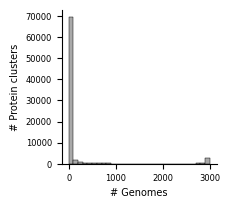

In [23]:
plt.subplots(figsize=(2,2))
sns.histplot(data=cluster_count, x='n_assemblies',binwidth=100, color='darkgrey', alpha=1, edgecolor='black')
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/ecoli_3k_u_plot.svg', dpi=300, bbox_inches='tight')

In [24]:
n_samples = [int(x) for x in np.linspace(1, 3_000, num=50)]
n_boot = 10

In [25]:
n_clusters_per_assembly_list = list()
for n in tqdm(n_samples, position=0):
    for boot in range(n_boot):
        sampled_assemblies = set(assemblies.sample(n=n, random_state=boot))
        n_clusters = merged_predictions.loc[merged_predictions['assembly'].isin(sampled_assemblies), 
                                              'cluster_id'].nunique()
        n_clusters_per_assembly_list.append({'n_assemblies': n,
                                             'n_clusters': n_clusters, 
                                             'boot': boot})

100%|██████████| 50/50 [10:13<00:00, 12.28s/it]


In [26]:
n_clusters_per_assembly_df = (pd.DataFrame(n_clusters_per_assembly_list)
                              .groupby('n_assemblies')
                              .agg({'n_clusters': 'mean'})
                              .reset_index())

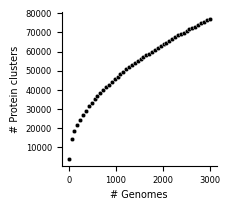

In [27]:
plt.subplots(figsize=(2, 2))
sns.scatterplot(data=n_clusters_per_assembly_df, x='n_assemblies', y='n_clusters',
                color='black', s=10)
sns.despine()
plt.xlabel('# Genomes')
plt.ylabel('# Protein clusters')
plt.savefig('../figures/ecoli_3k_clusters_per_assembly.svg', dpi=300, bbox_inches='tight')

In [28]:
assembly_n_genes = (merged_predictions.groupby('assembly')
                    .agg(total_genes=('product_accession', 'count'), 
                         predicted_defense_genes=('predicted_defensive', 'sum'), 
                         known_defense_genes=('defense_system_protein', 'sum'))
                    .reset_index())
assembly_n_genes['perc_predicted_defensive'] = (assembly_n_genes['predicted_defense_genes']/assembly_n_genes['total_genes'])*100
assembly_n_genes['perc_known_defensive'] = (assembly_n_genes['known_defense_genes']/assembly_n_genes['total_genes'])*100


In [29]:
assembly_n_genes[['perc_predicted_defensive', 'perc_known_defensive', 'predicted_defense_genes', 'known_defense_genes']].mean()

perc_predicted_defensive     0.664784
perc_known_defensive         0.125127
predicted_defense_genes     31.702333
known_defense_genes          5.958667
dtype: float64

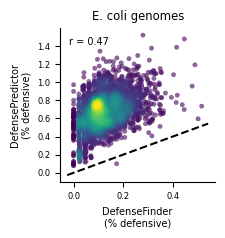

In [30]:
plt.subplots(figsize=(2,2))
gpplot.point_densityplot(data=assembly_n_genes, 
                         x='perc_known_defensive', 
                         y='perc_predicted_defensive',  
                         s=10)
gpplot.add_correlation(data=assembly_n_genes, 
                       x='perc_known_defensive', 
                       y='perc_predicted_defensive', 
                       fontfamily='Sans-Serif')
plt.xlabel('DefenseFinder\n(% defensive)')
plt.ylabel('DefensePredictor\n(% defensive)')
sns.despine()
gpplot.add_xy_line()
plt.title('E. coli genomes')
plt.savefig('../figures/systems_df_dp_ecoli_3k.svg', dpi=300, bbox_inches='tight')

In [31]:
assembly_n_genes.sort_values('perc_predicted_defensive')

,assembly,total_genes,predicted_defense_genes,known_defense_genes,perc_predicted_defensive,perc_known_defensive
1658,GCF_019265485.1,3855,3,0,0.077821,0.000000
748,GCF_002949675.1,3622,3,0,0.082827,0.000000
112,GCF_000500815.1,4075,4,0,0.098160,0.000000
113,GCF_000500875.1,4074,4,0,0.098184,0.000000
1659,GCF_019265505.1,4028,4,7,0.099305,0.173784
...,...,...,...,...,...,...
1778,GCF_020821845.1,4693,63,5,1.342425,0.106542
2652,GCF_040215525.1,5087,70,16,1.376057,0.314527
2868,GCF_902499885.1,5052,70,21,1.385590,0.415677
2889,GCF_902505245.1,5147,76,23,1.476588,0.446862


In [32]:
cluster_defense_frac = (merged_predictions.groupby('cluster_id')
                        .agg(mean_defensive=('predicted_defensive', 'mean'), 
                             members=('product_accession', 'count'))
                        .reset_index())

In [33]:
(cluster_defense_frac['mean_defensive'] == 1).sum()

2845

In [34]:
(cluster_defense_frac
 .query('mean_defensive > 0')
 .query('members >= 3')
 ['mean_defensive'] >= 0.5).sum()

1854

In [35]:
len(cluster_defense_frac
 .query('mean_defensive > 0')
 .query('members >= 3'))

2180

In [48]:
1854/2180

0.8504587155963302

<Axes: xlabel='mean_defensive', ylabel='Count'>

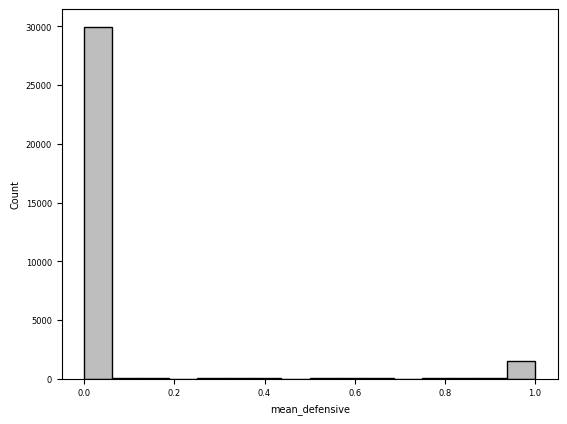

In [37]:
sns.histplot(data=cluster_defense_frac[cluster_defense_frac['members'] >= 3], 
             x='mean_defensive', color='darkgrey')

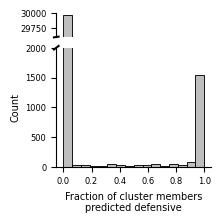

In [38]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                                      gridspec_kw={'hspace':0.15}, 
                                      figsize=(2, 2), 
                                      height_ratios=[1,5])
sns.histplot(data=cluster_defense_frac[cluster_defense_frac['members'] >= 3], 
             x='mean_defensive', color='darkgrey', ax=ax_bottom)
sns.histplot(data=cluster_defense_frac[cluster_defense_frac['members'] >= 3], 
             x='mean_defensive', color='darkgrey', ax=ax_top)
ax_top.set_ylim(30_000-2_000*1/5, 30_000)   
ax_bottom.set_ylim(0,2_000)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax_top.xaxis.set_visible(False)
ax_top.set_ylabel('')

kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax_bottom.set_xlabel("Fraction of cluster members\n"
           "predicted defensive")
plt.savefig('../figures/ecoli_3k_cluster_frac_defensive.svg', bbox_inches='tight')

## Get potential novel hits to query with HHblits

In [39]:
def assign_predicted_category(row):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['defense_homolog']:
        return 'Defense homolog in new context'
    else:
        return 'Putative novel defense gene'

In [40]:
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Putative novel defense gene']
predicted_defense_df = merged_predictions[merged_predictions['predicted_defensive']].copy()
predicted_defense_df['predicted_category'] = predicted_defense_df.apply(assign_predicted_category, axis=1)
predicted_defense_df['predicted_category'] = pd.Categorical(predicted_defense_df['predicted_category'], 
                                                    categories=hit_categories)

In [41]:
predicted_defense_df['predicted_category'].value_counts()

predicted_category
Defense homolog in new context        49048
Putative novel defense gene           35035
Defense homolog in expected system    11024
Name: count, dtype: int64

In [42]:
non_redundant_predictions = (predicted_defense_df
                             .sort_values(['predicted_category', 'mean_log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [43]:
non_redundant_predictions['predicted_category'].value_counts()

predicted_category
Putative novel defense gene           1926
Defense homolog in new context        1037
Defense homolog in expected system     697
Name: count, dtype: int64

In [44]:
putative_novel_df = non_redundant_predictions[non_redundant_predictions['predicted_category'] == 'Putative novel defense gene'].copy()

In [53]:
len(putative_novel_df)

1926

In [45]:
putative_novel_df['name'].value_counts().head(50)

name
hypothetical protein                                                   1267
DUF2971 domain-containing protein                                        34
ATP-binding protein                                                      26
restriction endonuclease                                                 26
HEPN domain-containing protein                                           25
AAA family ATPase                                                        16
P-loop NTPase fold protein                                               16
DUF4365 domain-containing protein                                        15
nucleoid-associated protein                                              15
HNH endonuclease                                                         14
SMEK domain-containing protein                                           13
PIN domain-containing protein                                            13
DUF262 domain-containing protein                                         12
DUF4145

In [46]:
novel_acc_out = '../data3/interim/ecoli_3k_putative_novel_accessions.txt'


In [47]:
putative_novel_df['product_accession'].to_csv(novel_acc_out, index=False, header=False)

In [50]:
faa_out = '../data3/interim/ecoli_3k_putative_novel_seqs.faa'


In [51]:
os.system(' '.join(['conda run -n beaker', 
                    'seqtk subseq', '../data/ecoli/interim/unique_seqs.faa', 
                    novel_acc_out, '>',
                    faa_out]))

0

In [52]:
merged_predictions.drop(columns='chromosome').to_parquet('../data3/processed/ecoli_3k_predictions.pq', index=False)